In [1]:
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np
import time

### VQE Overview:
https://arxiv.org/abs/2111.05176

### Optimizers
https://docs.pennylane.ai/en/stable/code/api/pennylane.GradientDescentOptimizer.html \
https://docs.pennylane.ai/en/stable/code/api/pennylane.QNGOptimizer.html \
https://docs.pennylane.ai/en/stable/code/api/pennylane.RotosolveOptimizer.html 

### Circuit Ansatz 
https://docs.pennylane.ai/en/stable/introduction/templates.html \
https://docs.pennylane.ai/en/stable/code/api/pennylane.AllSinglesDoubles.html \
https://docs.pennylane.ai/en/stable/code/api/pennylane.UCCSD.html

### Computational Chemistry Comparison and Benchmark DataBase
https://cccbdb.nist.gov/introx.asp \
H2: https://cccbdb.nist.gov/energy2x.asp

### qchem Functions: 
molecular_hamiltonian - 2nd Quantization of Molecule Hamiltonian and transformation from fermionic Hamiltonian to the qubit Hamiltonian: \
https://docs.pennylane.ai/en/stable/code/api/pennylane.qchem.molecular_hamiltonian.html \
hf_state - generates the occupation-number vector representing the Hartree-Fock state: \
https://docs.pennylane.ai/en/stable/code/api/pennylane.qchem.hf_state.html \
exitations - generates single and double excitations from a Hartree-Fock reference state: \
https://docs.pennylane.ai/en/stable/code/api/pennylane.qchem.excitations.html \
qml.grouping.group_observables -Groups pauli terms to reduce number of circuits evaluated \
https://docs.pennylane.ai/en/stable/code/api/pennylane.grouping.group_observables.html

In [2]:
symbols, coordinates = qchem.read_structure('structures/h2.xyz')
# determine how penny lane is doing 2nd quantization, ues basis set, and fermionic to qubit transformation
# error mitigation for vqe?
# 
h, qubits = qchem.molecular_hamiltonian(symbols, coordinates, name="h2",basis='sto-3g')
print('h:',h)
print('qubits:',qubits)

h:   (-0.24274280046615693) [Z2]
+ (-0.24274280046615687) [Z3]
+ (-0.0420789853934066) [I0]
+ (0.17771287502664973) [Z1]
+ (0.17771287502664976) [Z0]
+ (0.12293305045324411) [Z0 Z2]
+ (0.12293305045324411) [Z1 Z3]
+ (0.1676831943189928) [Z0 Z3]
+ (0.1676831943189928) [Z1 Z2]
+ (0.170597383650808) [Z0 Z1]
+ (0.17627640722428184) [Z2 Z3]
+ (-0.04475014386574869) [Y0 Y1 X2 X3]
+ (-0.04475014386574869) [X0 X1 Y2 Y3]
+ (0.04475014386574869) [Y0 X1 X2 Y3]
+ (0.04475014386574869) [X0 Y1 Y2 X3]
qubits: 4


In [3]:
electrons = 2  
hf_state = qchem.hf_state(electrons,qubits)
singles, doubles = qchem.excitations(electrons,qubits)
s_wires, d_wires = qml.qchem.excitations_to_wires(singles, doubles)

In [4]:
hf_state

tensor([1, 1, 0, 0], requires_grad=True)

In [5]:
dev = qml.device("braket.local.qubit", wires=qubits,shots=1000)

In [6]:
wires = dev.wires.tolist()

def circuit_ASD(params,wires):
    qml.templates.AllSinglesDoubles(params,wires,hf_state = hf_state,singles = singles,doubles =doubles)

In [7]:
def initialize_params(singles,doubles,np_seed=100):
    np.random.seed(seed=np_seed)
    return np.random.normal(0, np.pi, len(singles)+len(doubles))

In [8]:
print("Number of Pauli terms in h:", len(h.ops))
groups, coeffs = qml.grouping.group_observables(h.ops,h.coeffs)
print("Number of qubit-wise commuting groups:", len(groups))
h.compute_grouping()
wires = dev.wires.tolist()

Number of Pauli terms in h: 15
Number of qubit-wise commuting groups: 5


In [9]:
@qml.qnode(dev)
def energy_expval_ASD(params):
    circuit_ASD(params,wires)
    return qml.expval(h)

In [11]:
params0 = initialize_params(singles,doubles)
print(qml.draw(energy_expval_ASD)(params0))

0: ─╭BasisState(M0)─╭G²(3.62)─╭G(-5.50)──────────┤ ╭<𝓗>
1: ─├BasisState(M0)─├G²(3.62)─│─────────╭G(1.08)─┤ ├<𝓗>
2: ─├BasisState(M0)─├G²(3.62)─╰G(-5.50)─│────────┤ ├<𝓗>
3: ─╰BasisState(M0)─╰G²(3.62)───────────╰G(1.08)─┤ ╰<𝓗>


In [12]:
STEPSIZE = 0.4
opt = qml.GradientDescentOptimizer(stepsize=STEPSIZE)
ITERATIONS = 40

In [13]:
def run_vqe(energy_expval, opt,initial_params, iterations):
    energies = []
    runtime = []
    params = initial_params
    t0 = time.time()
    for i in range(iterations):
        params = opt.step(energy_expval,params)
        e = energy_expval(params)
        energies.append(e)
        ti = time.time()
        runtime.append(ti-t0)
        if (i+1) % 5 == 0:
            print(f"Completed iteration {i + 1}")
            print("Energy:", e)
            print("----------------")
    print(f"Optimized energy: {e} Ha")
    return energies,runtime

In [14]:
energies_ASD,runtime_ASD = run_vqe(energy_expval_ASD,opt,params0,ITERATIONS)

Completed iteration 5
Energy: -0.19520891062682616
----------------
Completed iteration 10
Energy: -0.8549692452194531
----------------
Completed iteration 15
Energy: -1.0673482900357776
----------------
Completed iteration 20
Energy: -1.130123522916435
----------------
Completed iteration 25
Energy: -1.1379545059164562
----------------
Completed iteration 30
Energy: -1.1477643636490906
----------------
Completed iteration 35
Energy: -1.1277490978439706
----------------
Completed iteration 40
Energy: -1.1391762495637716
----------------
Optimized energy: -1.1391762495637716 Ha


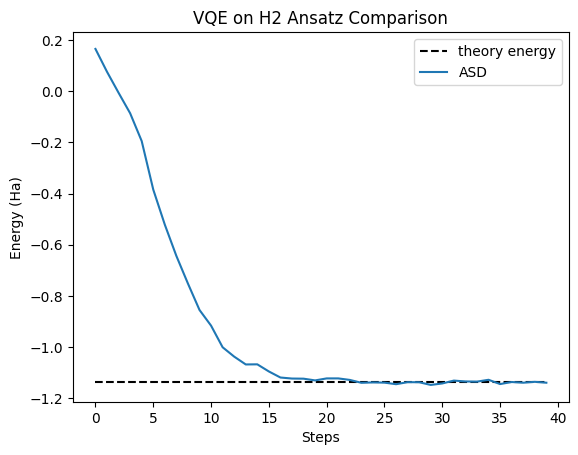

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

theory_energy = -1.137306 # Coupled Cluster STO-G3

plt.hlines(theory_energy, 0, ITERATIONS-1, linestyles="dashed", colors="black",label='theory energy')
plt.plot(energies_ASD,label='ASD')
plt.xlabel("Steps")
plt.ylabel("Energy (Ha)")
plt.title('VQE on H2 Ansatz Comparison')
plt.legend()

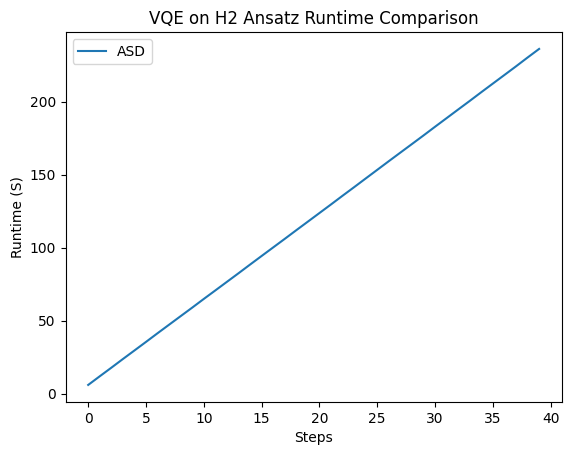

In [16]:
plt.plot(runtime_ASD,label='ASD')
plt.xlabel("Steps")
plt.ylabel("Runtime (S)")
plt.title('VQE on H2 Ansatz Runtime Comparison')
plt.legend()